In [2]:
import numpy as np
import matplotlib.pyplot as plt
from biaxread import *
from scipy.signal import medfilt
import matplotlib.patches as mpatches

%matplotlib inline

In [3]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def ReadExp(exp,path,disp_low,disp_high):
    data = ReadAscii('%s/%s/%s_data.txt'%(path,exp,exp))
    lower_row = find_nearest(np.ravel(data['LP_Disp']),disp_low)
    upper_row = find_nearest(np.ravel(data['LP_Disp']),disp_high)
    print lower_row,upper_row
    data = data[lower_row:upper_row]
    data['mu'] = data['mu'] - data['mu'][0]
    return data

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def rslope(x,y,window):
    """
    Takes a data vector and a window to produce a vector of the running average slope.
    The window specifies the number of points on either side of the central point, so
    the total number of points in the slope fitting is 2*window+1.  Fitting is
    done by the least squares method where the slope is defined by the equation below.
    the beginning and ends are padded with NaN, so fewer points are in those slope
    estimates.  Addition and subtraction to the totals is used so that the sum is not
    recomputed each time, speeding the process.

                    sum(x)*sum(y)
        Sum(x*y) -  -------------
                          n
    m = -------------------------
                     (sum(x))^2
        sum(x^2) - --------------
                          n
    """

    import numpy as np

    # Check that x and y are the same length
    if len(x) != len(y):
        print "Error: x and y must be the same length"
        return 0

    N = len(x) # Number of points in the dataset
    slopes = np.ones(N) # Make array for slopes

    # Pad data with window number of points NaN on either side
    x_padded = np.empty(2*window+N)
    x_padded[0:window] = 0
    x_padded[window:N+window] = x
    x_padded[N+window:2*window+N] = 0

    y_padded = np.empty(2*window+N)
    y_padded[0:window] = 0
    y_padded[window:N+window] = y
    y_padded[N+window:2*window+N] = 0

    sum_x    = np.sum(x_padded[0:2*window+1])
    sum_y    = np.sum(y_padded[0:2*window+1])
    sum_x_sq = np.sum(x_padded[0:2*window+1]*x_padded[0:2*window+1])
    sum_xy   = np.sum(x_padded[0:2*window+1]*y_padded[0:2*window+1])

    n = np.empty(N)
    n[0:window] = np.arange(window+1,2*window+1)
    n[window:N-window] = window*2+1
    n[N-window:N] = np.arange(2*window,window,-1)

    slopes[0] = (sum_xy - (sum_x*sum_y/n[0]))/(sum_x_sq - (sum_x*sum_x/n[0]))

    for i in range(1,N):
        sum_x    = sum_x - x_padded[i-1] + x_padded[2*window+i]
        sum_y    = sum_y - y_padded[i-1] + y_padded[2*window+i]
        sum_x_sq = sum_x_sq - x_padded[i-1]*x_padded[i-1] + \
            x_padded[2*window+i]*x_padded[2*window+i]
        sum_xy   = sum_xy - x_padded[i-1]*y_padded[i-1] +\
            x_padded[2*window+i]*y_padded[2*window+i]
        slopes[i] = (sum_xy - (sum_x*sum_y/n[i]))/(sum_x_sq - (sum_x*sum_x/n[i]))
    return slopes

# Path to folders of biax data
data_path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'

# Make Nice Plot Colors
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

#
# Read Data
#

path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'
#dis_low = 30*1000
#dis_high = 30.55*1000
#p4343 = ReadExp('p4343',path,30041,dis_high)
#p4345 = ReadExp('p4345',path,30034,dis_high)
#p4347 = ReadExp('p4347',path,30016,dis_high)
#p4342 = ReadExp('p4342',path,30031,dis_high)
#p4351 = ReadExp('p4351',path,30049,dis_high)

p4343_raw = ReadAscii(data_path+'/p4343/p4343_data.txt')
p4347_raw = ReadAscii(data_path+'/p4347/p4347_data.txt')
p4351_raw = ReadAscii(data_path+'/p4351/p4351_data.txt')


Number of records: 5887623
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
-------------------------------------------------
|        row_num|            mic|        5887623|
|        LP_Disp|            MPa|        5887623|
|     Shr_stress|         micron|        5887623|
|       nor_disp|            MPa|        5887623|
|     Nor_stress|            sec|        5887623|
|           Time|         micron|        5887623|
|         OB_Top|         micron|        5887623|
|      OB_Bottom|         micron|        5887623|
|        OB_Diff|             Hz|        5887623|
|      Samp_Freq|              .|        5887623|
|             mu|         micron|        5887623|
-------------------------------------------------

Number of records: 6212496
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
----------------------------------------------

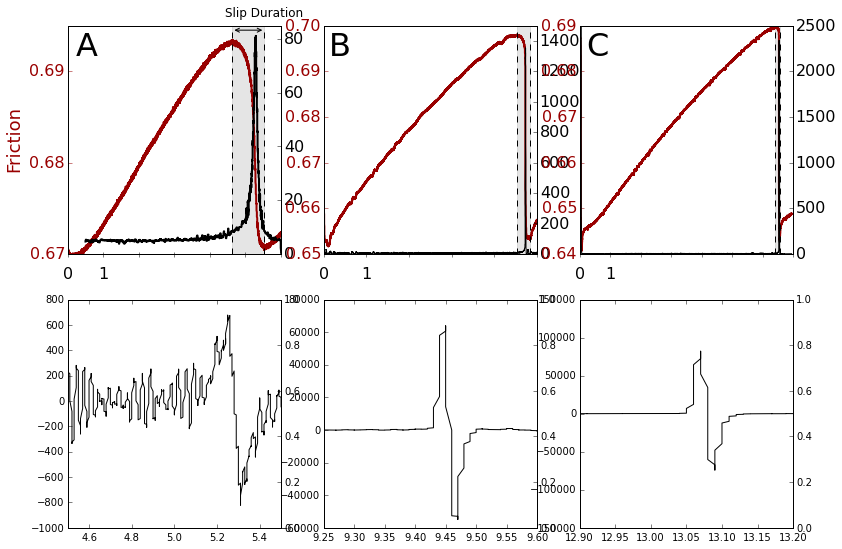

In [4]:
colors = [(255,150,150),(255,102,102),(255,51,51),(204,0,0), (153,0,0)]
colors = colors[::-1]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

vel_window = 11

# Setup figure and axes
# Generally plots is ~1.33x width to height (10,7.5 or 12,9)
fig = plt.figure(figsize=(13,9))
ax1 = plt.subplot(231)
ax1v = ax1.twinx()
ax2 = plt.subplot(232)
ax2v = ax2.twinx()
ax3 = plt.subplot(233)
ax3v = ax3.twinx()
ax4 = plt.subplot(234)
ax4v = ax4.twinx()
ax5 = plt.subplot(235)
ax5v = ax5.twinx()
ax6 = plt.subplot(236)
ax6v = ax6.twinx()


#
# Plot 1
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 413,3800095,3804529,3805433,0.900000,0.000652,3770,-21.272030,7036.910000,33692.700000,4.640566,81.252189

# Set labels and tick sizes
#ax1.set_xlabel(r'Time [sec]',fontsize=18)
ax1.set_ylabel(r'Friction',fontsize=18,color=colors[0])
#ax1v.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1v.tick_params(axis='both', which='major', labelsize=16)

# Change colors of plot axes
ax1.spines['left'].set_color(colors[0])
ax1.yaxis.label.set_color(colors[0])
ax1.tick_params(axis='y', colors=colors[0])

# Label Plot
ax1.text(0.04,0.87,'A',transform = ax1.transAxes,fontsize=32)

# Turns off chart clutter

# Turn off top and right tick marks
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.get_yaxis().set_ticks([0.67,0.68,0.69])
ax1v.get_xaxis().tick_bottom()
ax1v.get_yaxis().tick_right()
ax1v.get_yaxis().set_ticks([0,20,40,60,80])
ax1v.get_xaxis().set_ticks([0,1,2,3,4,5,6])
ax1.get_xaxis().set_ticklabels([0,1])

ax1.get_xaxis().set_tick_params(which='both', direction='inout',length=5)

y1 = 500
y2 = 5000
y3 = 5500
y4 = 5999
velocity = rslope(np.ravel(p4343_raw['Time'][3799900:3805900]),np.ravel(p4343_raw['OB_Top'][3799900:3805900]),11)
time = np.ravel(p4343_raw['Time'][3799900:3805900]-p4343_raw['Time'][3799900])
acceleration = rslope(np.ravel(p4343_raw['Time'][3799900:3805900]),velocity,11)

ax1v.plot(time[y1:y2],medfilt(velocity[y1:y2],35),color='k',zorder=0,linewidth=2)
ax1v.plot(time[y2:y3],velocity[y2:y3],color='k',zorder=0,linewidth=2)
ax1v.plot(time[y3:y4],medfilt(velocity[y3:y4],35),color='k',zorder=0,linewidth=2)

ax4.plot(time,acceleration,color='k')
ax4.set_xlim(4.5,5.5)

# Plotting
ax1.plot(p4343_raw['Time'][3799900:3805900]-p4343_raw['Time'][3799900],p4343_raw['mu'][3799900:3805900],label='6 MPa',color=colors[0],zorder=1,linewidth=2)

# Mark the slip duration window
ax1.axvspan(p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900], p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900], alpha=0.1, color='k')
ax1.axvline(x=p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900],linestyle='--',color='k')
ax1.axvline(x=p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900],linestyle='--',color='k')

# Add double headed arrow
arrow_x = [p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900], p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900]]
arrow_y = [0.6945,0.6945]
ax1.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'})
ax1.text(arrow_x[0]-0.2,0.696,'Slip Duration',fontsize=12)

# Set limits
ax1.set_xlim(0,6)
ax1v.set_xlim(0,6)
ax1.set_ylim(0.67,0.695)
ax1v.set_ylim(0,85)

#
# Plot 2
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 246,3784516,3793363,3793975,0.610000,0.000603,4579,-19.370876,6430.870000,33305.500000,0.000000,1548.320158

start = 3784300
end = 3794300
fail_row = 3793363
end_row = 3793975

# Set labels and tick sizes
#ax2.set_xlabel(r'Time [sec]',fontsize=18)
#ax2.set_ylabel(r'Friction',fontsize=18,color=colors[0])
#ax2v.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2v.tick_params(axis='both', which='major', labelsize=16)

# Change colors of plot axes
ax2.spines['left'].set_color(colors[0])
ax2.yaxis.label.set_color(colors[0])
ax2.tick_params(axis='y', colors=colors[0])

# Label Plot
ax2.text(0.04,0.87,'B',transform = ax2.transAxes,fontsize=32)

# Turns off chart clutter

# Turn off top and right tick marks
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
#ax2.get_yaxis().set_ticks([0.67,0.68,0.69])
ax2v.get_xaxis().tick_bottom()
ax2v.get_yaxis().tick_right()
#ax2v.get_yaxis().set_ticks([0,20,40,60,80])
#ax2v.get_xaxis().set_ticks([0,1,2,3,4,5,6])
ax2.get_xaxis().set_ticklabels([0,1])

ax2.get_xaxis().set_tick_params(which='both', direction='inout',length=5)

#y1 = 500
#y2 = 5000
#y3 = 5500
#y4 = 5999
velocity = rslope(np.ravel(p4347_raw['Time'][start:end]),np.ravel(p4347_raw['OB_Top'][start:end]),11)
time = np.ravel(p4347_raw['Time'][start:end]-p4347_raw['Time'][start])
acceleration = rslope(np.ravel(p4347_raw['Time'][start:end]),velocity,11)
ax2v.plot(time,velocity,color='k')

ax5.plot(time,acceleration,color='k')
ax5.set_xlim(9.25,9.6)

#ax2v.plot(time[y1:y2],medfilt(velocity[y1:y2],35),color='k',zorder=0,linewidth=2)
#ax2v.plot(time[y2:y3],velocity[y2:y3],color='k',zorder=0,linewidth=2)
#ax2v.plot(time[y3:y4],medfilt(velocity[y3:y4],35),color='k',zorder=0,linewidth=2)

# Plotting
ax2.plot(p4347_raw['Time'][start:end]-p4347_raw['Time'][start],p4347_raw['mu'][start:end],label='10 MPa',color=colors[0],zorder=1,linewidth=2)

# Mark the slip duration window
ax2.axvspan(p4347_raw['Time'][fail_row]-p4347_raw['Time'][start], p4347_raw['Time'][end_row]-p4347_raw['Time'][start], alpha=0.1, color='k')
ax2.axvline(x=p4347_raw['Time'][fail_row]-p4347_raw['Time'][start],linestyle='--',color='k')
ax2.axvline(x=p4347_raw['Time'][end_row]-p4347_raw['Time'][start],linestyle='--',color='k')

# Add double headed arrow
#arrow_x = [p4347_raw['Time'][3804529]-p4347_raw['Time'][3799900], p4347_raw['Time'][3805433]-p4347_raw['Time'][3799900]]
#arrow_y = [0.6945,0.6945]
#ax2.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'})
#ax2.text(arrow_x[0]-0.2,0.696,'Slip Duration',fontsize=12)

# Set limits
#ax2.set_xlim(0,6)
#ax2v.set_xlim(0,6)
#ax2.set_ylim(0.67,0.695)
ax2v.set_ylim(0,1500)


#
# Plot 3
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 191,3715117,3727806,3728118,0.310000,0.000414,7745,-13.029683,5856.350000,33139.100000,-0.000000,3696.936759

start = 3715000
end = 3728900
fail_row = 3727806
end_row = 3728118

# Set labels and tick sizes
#ax3.set_xlabel(r'Time [sec]',fontsize=18)
#ax3.set_ylabel(r'Friction',fontsize=18,color=colors[0])
#ax3v.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3v.tick_params(axis='both', which='major', labelsize=16)

# Change colors of plot axes
ax3.spines['left'].set_color(colors[0])
ax3.yaxis.label.set_color(colors[0])
ax3.tick_params(axis='y', colors=colors[0])

# Label Plot
ax3.text(0.04,0.87,'C',transform = ax3.transAxes,fontsize=32)

# Turns off chart clutter

# Turn off top and right tick marks
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()
#ax3.get_yaxis().set_ticks([0.67,0.68,0.69])
ax3v.get_xaxis().tick_bottom()
ax3v.get_yaxis().tick_right()
#ax3v.get_yaxis().set_ticks([0,20,40,60,80])
#ax3v.get_xaxis().set_ticks([0,1,2,3,4,5,6])
ax3.get_xaxis().set_ticklabels([0,1])

ax3.get_xaxis().set_tick_params(which='both', direction='inout',length=5)

#y1 = 500
#y2 = 5000
#y3 = 5500
#y4 = 5999
velocity = rslope(np.ravel(p4351_raw['Time'][start:end]),np.ravel(p4351_raw['OB_Top'][start:end]),11)
acceleration = rslope(np.ravel(p4351_raw['Time'][start:end]),velocity,11)
time = np.ravel(p4351_raw['Time'][start:end]-p4351_raw['Time'][start])

ax3v.plot(time,velocity,color='k')
ax6.plot(time,acceleration,color='k')
ax6.set_xlim(12.9,13.2)

#ax3v.plot(time[y1:y2],medfilt(velocity[y1:y2],35),color='k',zorder=0,linewidth=2)
#ax3v.plot(time[y2:y3],velocity[y2:y3],color='k',zorder=0,linewidth=2)
#ax3v.plot(time[y3:y4],medfilt(velocity[y3:y4],35),color='k',zorder=0,linewidth=2)

# Plotting
ax3.plot(p4351_raw['Time'][start:end]-p4351_raw['Time'][start],p4351_raw['mu'][start:end],label='10 MPa',color=colors[0],zorder=1,linewidth=2)

# Mark the slip duration window
ax3.axvspan(p4351_raw['Time'][fail_row]-p4351_raw['Time'][start], p4351_raw['Time'][end_row]-p4351_raw['Time'][start], alpha=0.1, color='k')
ax3.axvline(x=p4351_raw['Time'][fail_row]-p4351_raw['Time'][start],linestyle='--',color='k')
ax3.axvline(x=p4351_raw['Time'][end_row]-p4351_raw['Time'][start],linestyle='--',color='k')

# Add double headed arrow
#arrow_x = [p4351_raw['Time'][3804529]-p4351_raw['Time'][3799900], p4351_raw['Time'][3805433]-p4351_raw['Time'][3799900]]
#arrow_y = [0.6945,0.6945]
#ax3.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'})
#ax3.text(arrow_x[0]-0.2,0.696,'Slip Duration',fontsize=12)

# Set limits
#ax3.set_xlim(0,6)
#ax3v.set_xlim(0,6)
#ax3.set_ylim(0.67,0.695)
ax3v.set_ylim(0,2500)

plt.savefig('figure.png', bbox_inches="tight")

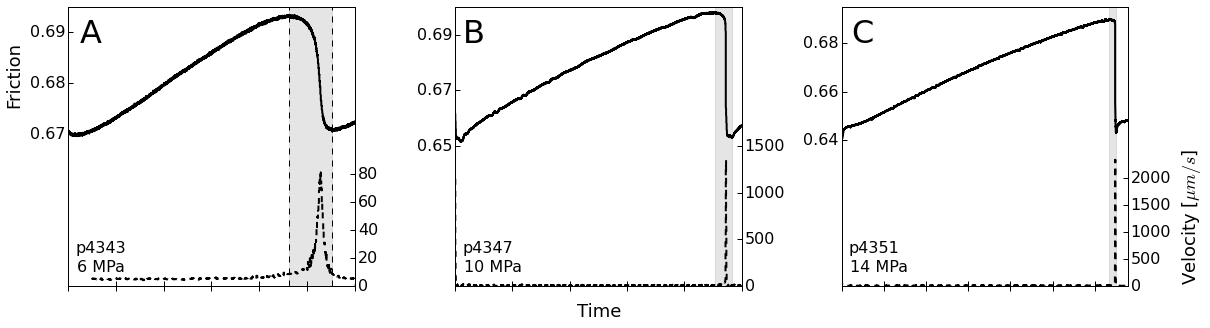

In [5]:
colors = [(0,0,0),(115,115,115),(255,150,150),(255,102,102),(255,51,51),(204,0,0), (153,0,0)]
#colors = colors[::-1]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

vel_window = 11

# Setup figure and axes
# Generally plots is ~1.33x width to height (10,7.5 or 12,9)
fig = plt.figure(figsize=(19,5))
ax1 = plt.subplot(131)
ax1v = ax1.twinx()
ax2 = plt.subplot(132)
ax2v = ax2.twinx()
ax3 = plt.subplot(133)
ax3v = ax3.twinx()

plt.subplots_adjust(wspace=0.35)

#
# Plot 1
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 413,3800095,3804529,3805433,0.900000,0.000652,3770,-21.272030,7036.910000,33692.700000,4.640566,81.252189

# Set labels and tick sizes
#ax1.set_xlabel(r'Time [sec]',fontsize=18)
ax1.set_ylabel(r'Friction',fontsize=18,color=colors[0])
#ax1v.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1v.tick_params(axis='both', which='major', labelsize=16)

# Change colors of plot axes
ax1.spines['left'].set_color(colors[0])
ax1.yaxis.label.set_color(colors[0])
ax1.tick_params(axis='y', colors=colors[0])

# Label Plot
ax1.text(0.04,0.87,'A',transform = ax1.transAxes,fontsize=32)
ax1.text(0.03,0.12,'p4343',transform = ax1.transAxes,fontsize=16)
ax1.text(0.03,0.05,'6 MPa',transform = ax1.transAxes,fontsize=16)

# Turns off chart clutter

# Turn off top and right tick marks
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.get_yaxis().set_ticks([0.67,0.68,0.69])
ax1v.get_xaxis().tick_bottom()
ax1v.get_yaxis().tick_right()
ax1v.get_yaxis().set_ticks([0,20,40,60,80])
ax1v.get_xaxis().set_ticks([0,1,2,3,4,5,6])
ax1.get_xaxis().set_ticklabels([])

ax1.get_xaxis().set_tick_params(which='both', direction='inout',length=10,width=1)
ax1.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)
ax1v.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)

y1 = 500
y2 = 5000
y3 = 5500
y4 = 5999
velocity = rslope(np.ravel(p4343_raw['Time'][3799900:3805900]),np.ravel(p4343_raw['OB_Top'][3799900:3805900]),11)
time = np.ravel(p4343_raw['Time'][3799900:3805900]-p4343_raw['Time'][3799900])

ax1v.plot(time[y1:y2],medfilt(velocity[y1:y2],35),color='k',zorder=0,linewidth=2,linestyle='--')
ax1v.plot(time[y2:y3],velocity[y2:y3],color='k',zorder=0,linewidth=2,linestyle='--')
ax1v.plot(time[y3:y4],medfilt(velocity[y3:y4],35),color='k',zorder=0,linewidth=2,linestyle='--')

# Plotting
ax1.plot(p4343_raw['Time'][3799900:3805900]-p4343_raw['Time'][3799900],p4343_raw['mu'][3799900:3805900],label='6 MPa',color=colors[0],zorder=1,linewidth=2)

# Mark the slip duration window
ax1.axvspan(p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900], p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900], alpha=0.1, color='k')
ax1.axvline(x=p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900],linestyle='--',color='k')
ax1.axvline(x=p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900],linestyle='--',color='k')

# Add double headed arrow
#arrow_x = [p4343_raw['Time'][3804529]-p4343_raw['Time'][3799900], p4343_raw['Time'][3805433]-p4343_raw['Time'][3799900]]
#arrow_y = [0.6945,0.6945]
#arrow_y = [0.696,0.696]
#ax1.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'}, annotation_clip=False)
#ax1.text(arrow_x[0]-0.3,0.698,'Slip Duration',fontsize=12)

# Set limits
ax1.set_xlim(0,6)
ax1v.set_xlim(0,6)
ax1.set_ylim(0.64,0.695)
ax1v.set_ylim(0,200)

#
# Plot 2
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 246,3784516,3793363,3793975,0.610000,0.000603,4579,-19.370876,6430.870000,33305.500000,0.000000,1548.320158

start = 3784300
end = 3794300
fail_row = 3793363
end_row = 3793975

# Set labels and tick sizes
ax2.set_xlabel(r'Time',fontsize=18)
#ax2.set_ylabel(r'Friction',fontsize=18,color=colors[0])
#ax2v.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2v.tick_params(axis='both', which='major', labelsize=16)

# Change colors of plot axes
ax2.spines['left'].set_color(colors[0])
ax2.yaxis.label.set_color(colors[0])
ax2.tick_params(axis='y', colors=colors[0])

# Label Plot
ax2.text(0.04,0.87,'B',transform = ax2.transAxes,fontsize=32)
ax2.text(0.03,0.12,'p4347',transform = ax2.transAxes,fontsize=16)
ax2.text(0.03,0.05,'10 MPa',transform = ax2.transAxes,fontsize=16)

# Turns off chart clutter

# Turn off top and right tick marks
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.get_yaxis().set_ticks([0.65,0.67,0.69])
ax2v.get_xaxis().tick_bottom()
ax2v.get_yaxis().tick_right()
ax2v.get_yaxis().set_ticks([0,500,1000,1500])
#ax2v.get_xaxis().set_ticks([0,1,2,3,4,5,6])
ax2.get_xaxis().set_ticklabels([])

ax2.get_xaxis().set_tick_params(which='both', direction='inout',length=10,width=1)
ax2.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)
ax2v.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)

#y1 = 500
#y2 = 5000
#y3 = 5500
#y4 = 5999
velocity = rslope(np.ravel(p4347_raw['Time'][start:end]),np.ravel(p4347_raw['OB_Top'][start:end]),11)
time = np.ravel(p4347_raw['Time'][start:end]-p4347_raw['Time'][start])
ax2v.plot(time,velocity,color='k',linewidth=2,linestyle='--')

#ax2v.plot(time[y1:y2],medfilt(velocity[y1:y2],35),color='k',zorder=0,linewidth=2)
#ax2v.plot(time[y2:y3],velocity[y2:y3],color='k',zorder=0,linewidth=2)
#ax2v.plot(time[y3:y4],medfilt(velocity[y3:y4],35),color='k',zorder=0,linewidth=2)

# Plotting
ax2.plot(p4347_raw['Time'][start:end]-p4347_raw['Time'][start],p4347_raw['mu'][start:end],label='10 MPa',color=colors[0],zorder=1,linewidth=2)

# Mark the slip duration window
ax2.axvspan(p4347_raw['Time'][fail_row]-p4347_raw['Time'][start], p4347_raw['Time'][end_row]-p4347_raw['Time'][start], alpha=0.1, color='k')
#ax2.axvline(x=p4347_raw['Time'][fail_row]-p4347_raw['Time'][start],linestyle='--',color='k')
#ax2.axvline(x=p4347_raw['Time'][end_row]-p4347_raw['Time'][start],linestyle='--',color='k')

# Add double headed arrow
#arrow_x = [p4347_raw['Time'][3804529]-p4347_raw['Time'][3799900], p4347_raw['Time'][3805433]-p4347_raw['Time'][3799900]]
#arrow_y = [0.6945,0.6945]
#ax2.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'})
#ax2.text(arrow_x[0]-0.2,0.696,'Slip Duration',fontsize=12)

# Add double headed arrow
#arrow_x = [p4347_raw['Time'][fail_row]-p4347_raw['Time'][start], p4347_raw['Time'][end_row]-p4347_raw['Time'][start]]
#arrow_y = [0.702,0.702]
#ax2.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'}, annotation_clip=False)
#ax2.text(arrow_x[0]-0.88,0.7045,'Slip Duration',fontsize=12)

# Set limits
#ax2.set_xlim(0,6)
#ax2v.set_xlim(0,6)
#ax2.set_ylim(0.67,0.695)
# Set limits
ax2.set_ylim(0.6,0.7)
ax2v.set_ylim(0,3000)


#
# Plot 3
#

# Event,StartRow,FailRow,EndRow,SlipDuration,Stiffness,NptsStiffness,StiffnessIntercept,FailTime,FailDisplacement,50_Mean_Velocity,Peak_Velocity
# 191,3715117,3727806,3728118,0.310000,0.000414,7745,-13.029683,5856.350000,33139.100000,-0.000000,3696.936759

start = 3715000
start = 3715100
end = 3728900
end = 3728700
fail_row = 3727806
end_row = 3728118

# Set labels and tick sizes
#ax3.set_xlabel(r'Time [sec]',fontsize=18)
#ax3.set_ylabel(r'Friction',fontsize=18,color=colors[0])
ax3v.set_ylabel(r'Velocity [$\mu m/s$]',fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3v.tick_params(axis='both', which='major', labelsize=16)

# Change colors of plot axes
ax3.spines['left'].set_color(colors[0])
ax3.yaxis.label.set_color(colors[0])
ax3.tick_params(axis='y', colors=colors[0])

# Label Plot
ax3.text(0.04,0.87,'C',transform = ax3.transAxes,fontsize=32)
ax3.text(0.03,0.12,'p4351',transform = ax3.transAxes,fontsize=16)
ax3.text(0.03,0.05,'14 MPa',transform = ax3.transAxes,fontsize=16)

# Turns off chart clutter

# Turn off top and right tick marks
ax3.get_xaxis().tick_bottom()
ax3.get_yaxis().tick_left()
ax3.get_yaxis().set_ticks([0.64,0.66,0.68])
ax3v.get_xaxis().tick_bottom()
ax3v.get_yaxis().tick_right()
ax3v.get_yaxis().set_ticks([0,500,1000,1500,2000])
#ax3v.get_xaxis().set_ticks([0,1,2,3,4,5,6])
ax3.get_xaxis().set_ticklabels([])

ax3.get_xaxis().set_tick_params(which='both', direction='inout',length=10,width=1)
ax3.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)
ax3v.get_yaxis().set_tick_params(which='both', direction='in',length=5,width=1)


velocity = rslope(np.ravel(p4351_raw['Time'][start:end]),np.ravel(p4351_raw['OB_Top'][start:end]),11)
time = np.ravel(p4351_raw['Time'][start:end]-p4351_raw['Time'][start])

# Plotting
ax3.plot(p4351_raw['Time'][start:end]-p4351_raw['Time'][start],p4351_raw['mu'][start:end],label='10 MPa',color=colors[0],zorder=1,linewidth=2)
ax3v.plot(time,velocity,color='k',linewidth=2,linestyle='--')

# Mark the slip duration window
ax3.axvspan(p4351_raw['Time'][fail_row]-p4351_raw['Time'][start], p4351_raw['Time'][end_row]-p4351_raw['Time'][start], alpha=0.1, color='k')
#ax3.axvline(x=p4351_raw['Time'][fail_row]-p4351_raw['Time'][start],linestyle='--',color='k')
#ax3.axvline(x=p4351_raw['Time'][end_row]-p4351_raw['Time'][start],linestyle='--',color='k')

# Add double headed arrow
#arrow_x = [p4351_raw['Time'][fail_row]-p4351_raw['Time'][start], p4351_raw['Time'][end_row]-p4351_raw['Time'][start]]
#arrow_y = [0.698,0.698]
#ax3.annotate('', xy=(arrow_x[0], arrow_y[0]), xycoords='data',xytext=(arrow_x[1], arrow_y[1]), textcoords='data',arrowprops={'arrowstyle': '<->'}, annotation_clip=False)
#ax3.text(arrow_x[0]-1.8,0.7,'Slip Duration',fontsize=12)

# Set limits
ax3.set_ylim(0.58,0.695)
ax3v.set_ylim(0,5200)
ax3.set_xlim(0,p4351_raw['Time'][end]-p4351_raw['Time'][start])

ax1.yaxis.set_label_coords(-0.15,0.75)
ax3v.yaxis.set_label_coords(1.18,0.25)

plt.savefig('figure.pdf', bbox_inches="tight")